# Exponential smoothing

We will illustrate the family of forecasting techniques based on exponential smoothing:
1. Simple exponential smoothing: Forecasts are based on a weighted average of all past data, with the greatest weight on the most recent observation, and weights declining exponentially into the past.
2. Double exponential smoothing: Forecasts are based on a weighted average of not only the recent *level* of the data, but also its recent *trend.*
3. Triple exponential smoothing (also called Holt-Winters): Forecasts are based on a weighted average of recent level, trend, and seasonal effects.

These techniques are relatively simple, but are also extremely fast, flexible, and powerful ways to build forecasts for a wide range of data series without much knowledge about them. As such, they are some of the most popular forecasting tools in practice.

As always, we start by importing the necessary packages and configuration information.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import fredapi

from scipy.optimize import minimize

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import os
from dotenv import load_dotenv
load_dotenv();

## 1. Simple exponential smoothing with GDP growth rate

GDP is one of the most widely studied datasets for forecasting, so we will use it for a lot of examples in this class. We start by downloading and visualizing the series. Then we will use it to apply our exponential smoothing methods.

For simple and double smoothing, we will focus on seasonally-adjusted GDP, which is the most widely-reported number. In many settings you will actually want to work with the non-adjusted numbers. We will get to that in the last example, triple exponential smoothing.

Note that the series we download below is reported in billions of dollars, after seasonal adjustments, *and* is annualized (that is, multiplied by 4). To avoid numerical problems in our manual forecast calculations below, we will divide by 1000 so the numbers are in trillions. And to compare better with the non-adjusted data in the last section, we will also divide by 4 so the data are no longer annualized.

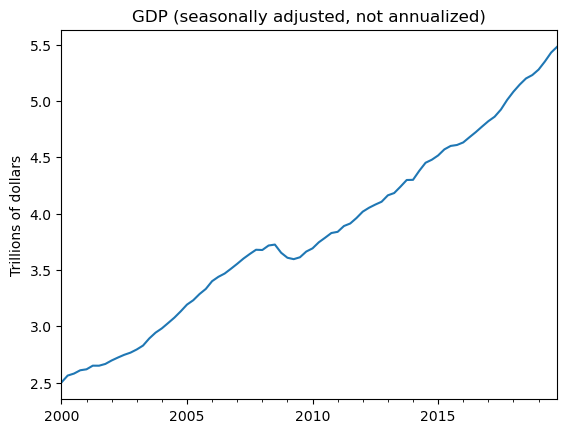

In [2]:
GDP = fredapi.Fred().get_series('GDP' , 
    observation_start = '2000-01-01', observation_end = '2019-12-31', 
    frequency='q', aggregation_method = 'eop').resample('QE').first()
GDP = GDP / 1000
GDP = GDP / 4
GDP.plot(title="GDP (seasonally adjusted, not annualized)",ylabel="Trillions of dollars");

To illustrate simple exponential smoothing, we will focus on  the *quarterly growth rate* in seasonally-adjusted GDP.

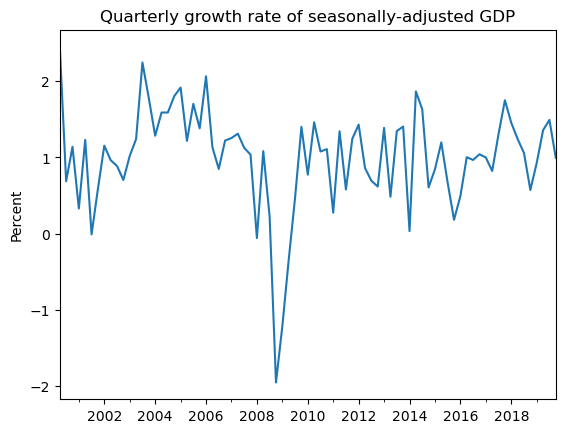

In [3]:
GDP_1q = 100*( GDP.diff() / GDP.shift() ).dropna()
GDP_1q.plot(title="Quarterly growth rate of seasonally-adjusted GDP",ylabel="Percent");

Last week, we saw that moving averages (MA) are one way of smoothing out noisy series like this to focus on the trend. Simple exponential smoothing (SES) will have its own way of accomplishing this. It is better for forecasting because it only uses past data (not future data), and applies a weighted-average approach with the most weight on the last observation. 

To run an SES algorithm, we can use the ExponentialSmoothing method (imported at the top of this notebook). In this method we specify the dataset that we want to use (GDP_1q), and the options trend=None and seasonal=None to  tell the code that this is simple smoothing, not double or triple (see later examples). Then we use the fit() method to actually run the model. The results are saved in an object called SES_results.

In [4]:
SES_results = ExponentialSmoothing(GDP_1q,trend=None,seasonal=None).fit()

Now that we have the results, we can look at lots of information about them. 

First, we can plot the data, and the fitted values from the SES algorithm. Fitted values mean different things in different places in statistics. With exponential smoothing approaches specifically, the "fitted values" are the forecasts that are made at each date, based on all the information available up to that point. So we can compare them with data on the same date to see how well the model performed. 

However, keep in mind that $\alpha$ was chosen to make this performance as good as possible "in-sample." So the true test of the model would be to see how it performs on a *future* dataset ("out of sample").

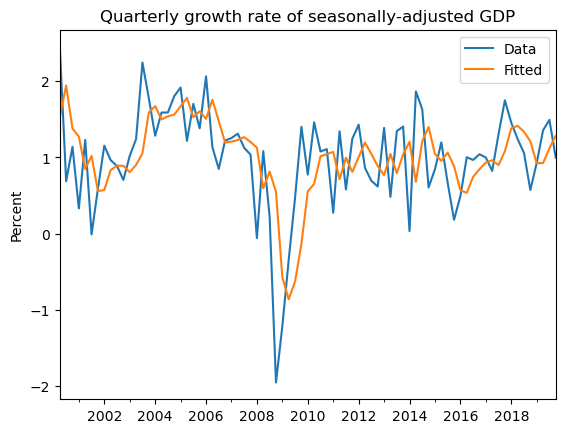

In [5]:
GDP_1q.plot(legend=True,label="Data",
            title="Quarterly growth rate of seasonally-adjusted GDP",
           ylabel="Percent");
SES_results.fittedvalues.plot(legend=True,label="Fitted");

To compare with the notation in the slides: The blue line above is the raw data on GDP growth rates rates (stored in the "GDP_1q" object) and is represented as $y_t$ in the slides. The orange line is the list of "forecasts" that we build from the SES procedure and is represented as $F_t$ in the slides.

We can also look at the computer's choice of initial values and model parameters. The output shows us that:

- The computer set its initial "forecast" $F_1$ equal to approximately 1.527 (listed under 'initial_level'). As discussed in the slides from class, this choice was made through an algorithm that is complicated and difficult for us to match manually. It is also not very important to understand exactly how the computer chose this value, because any choice of $F_1$ will only matter for the first few observations in the data.
- After choosing its value of $F_1$, the computer experimented with different value of $\alpha$, until it settled on a value of approximately 0.449 as its optimal choice (listed under 'smoothing_level'). As discussed in the slides from class, this choice was made to minimize the sum of squared forecast errors. The next code block will perform the same approach manually.
- All the other values are missing, because they relate to options that we are not using yet. (This will change in later examples.)

In [6]:
SES_results.params

{'smoothing_level': np.float64(0.44885865271658687),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(1.5265686651198092),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

The code below matches the above results (as closely as we would ever need for practical purposes):

In [7]:
# This function returns a list of one-step forecasts, given a choice of alpha
def SES_forecasts_manual(alpha):
    # Create an empty list of forecasts, with one extra row for the final forecast.
    # To do this, we create an empty series, copying the index of the raw data, and adding one value.
    N = len(GDP_1q)
    forecasts = pd.Series(index=GDP_1q.index.insert(N,GDP_1q.index.max() + 1*GDP_1q.index.freq),dtype='float64')
    # Initialize the first "forecast" F1
    # One common approach is to use the first observation from the data:
#     forecasts.iloc[0] = GDP_1q.iloc[0]
    # If we want to match the statsmodels approach as closely as possible, we can initialize at the value it chose:
    forecasts.iloc[0] = SES_results.params['initial_level']
    # Fill in the rest of the forecasts following the SES algorithm
    for i in range(0,N):
        forecasts.iloc[i+1] = alpha*GDP_1q.iloc[i] + (1-alpha)*forecasts.iloc[i]
    return forecasts

# This function returns the sum of squared one-step forecast errors
def SSE(alpha):
    forecasts = SES_forecasts_manual(alpha)
    errors = GDP_1q - forecasts
    SSE = (errors**2).sum()
    return SSE

# Use scipy's minimize function to search for the value of alpha that achieves the lowest SSE.
# The first input is the function that it is trying to minimize, the second is an initial guess about alpha.
optimization_results = minimize(SSE,0)

# Extract that value of alpha from the results
optimal_alpha = optimization_results.x[0]
print(f"Optimal value of alpha (by hand): {optimal_alpha : 6.5f}")

Optimal value of alpha (by hand):  0.44886


Plot our manual forecasts and the statsmodels forecasts for comparison.

- If we initialized $F_1$ at the value that statsmodels chose, we won't be able to see any difference.
- If we initialized it at another value, there will be some difference between the two lines in the first few months, then no great difference after that.

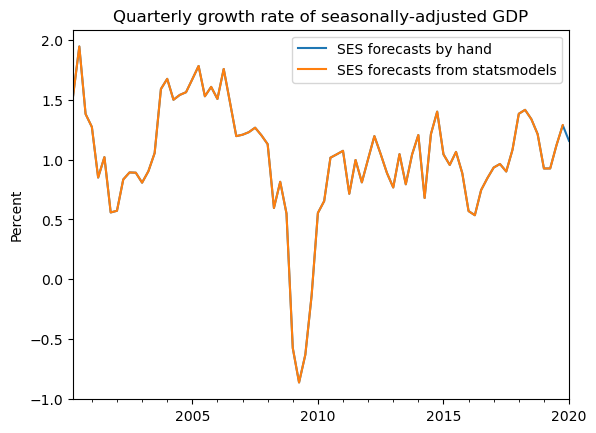

In [8]:
SES_forecasts_manual(optimal_alpha).plot(legend=True,label="SES forecasts by hand",
                                         title="Quarterly growth rate of seasonally-adjusted GDP",
                                        ylabel="Percent");
SES_results.fittedvalues.plot(legend=True,label="SES forecasts from statsmodels");

Finally, the results come with a "forecast" function that can be used to build out-of-sample forecasts beyond the end of the data. However, forecasts from simple exponential smoothing are not very interesting. It's just the most recent average, copied many times over. While SES (like moving-average smoothing) can help *us* to see the trend, the procedure itself does not have any awareness of that trend, only of the current level of the series. Double exponential smoothing (next section) will attempt to improve on this front.

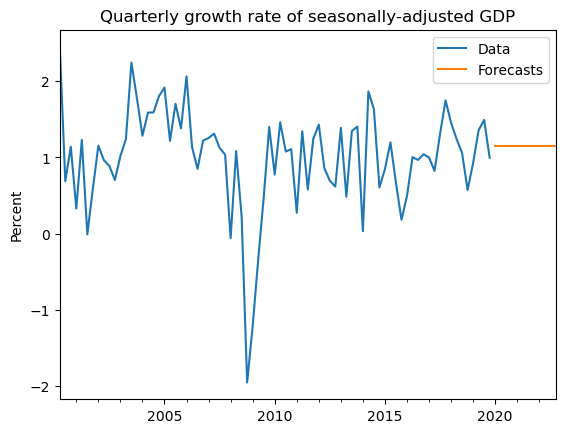

In [9]:
SES_forecasts_OOS = SES_results.forecast(12)
GDP_1q.plot(legend=True,label="Data",
            title="Quarterly growth rate of seasonally-adjusted GDP",
           ylabel="Percent");
SES_forecasts_OOS.plot(legend=True,label="Forecasts");

## 2. Double exponential smoothing with seasonally adjusted GDP

Let's suppose you want to forecast the *level* of (seasonally-adjusted) GDP in a given quarter instead of its growth rate. Look again at what this raw data looks like:

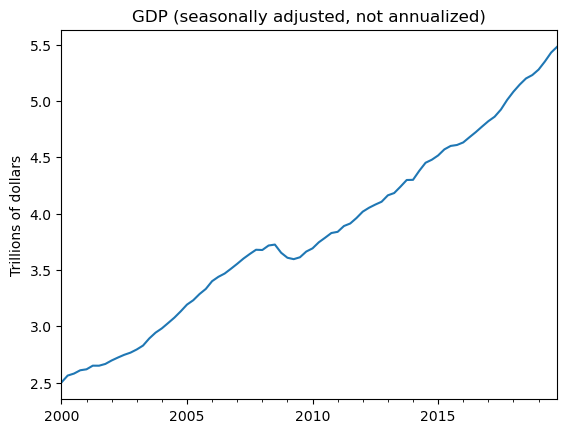

In [10]:
GDP.plot(title="GDP (seasonally adjusted, not annualized)",ylabel="Trillions of dollars");

Clearly, the above series trend upward. Simple exponential smoothing does not work so well in this setting, because it has no way to pick up on that trend: It can only pick up on where the series has recently been, not figure out which direction it is going. For this reason, its "optimal" value turns out to be $\alpha=1$, which means just predicting each next date with wherever the series is right now. This is called a "random walk" forecast and is not much of a model at all.

To illustrate this, let's try estimating a SES model on this series. The model results also contain the sum of squared errors for this model (SES_results.sse). We will compare this with the results of our other approaches below.

SSE:  0.16361
Optimal alpha:  1.00000


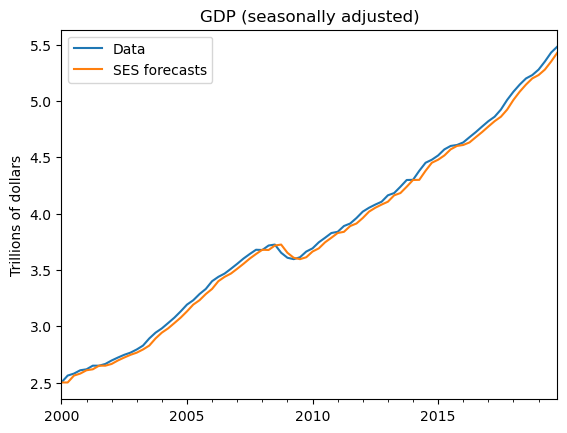

In [11]:
SES_results = ExponentialSmoothing(GDP,trend=None,seasonal=None).fit()
GDP.plot(legend=True,label="Data",ylabel="Trillions of dollars",title="GDP (seasonally adjusted)")
SES_results.fittedvalues.plot(legend=True,label="SES forecasts")
print(f"SSE: {SES_results.sse : 6.5f}")
print(f"Optimal alpha: {SES_results.params['smoothing_level'] : 6.5f}")

Looking at the results, the model just sets $\alpha=1$, which is essentially "giving up" and predicting each date using the previous date.

As with our earlier example, the forecasts that we generate from this approach are just a constant value. But in that earlier example, at least the series really did look likely to stay in the neighborhood of that constant prediction, so you could argue that it was the best prediction we could have hoped for. Here the prediction simply fails to recognize the trend in the data and is just clearly wrong.

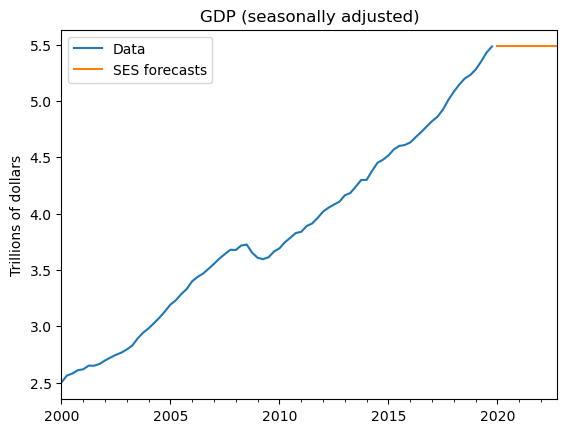

In [12]:
SES_results_OOS = SES_results.forecast(12)
GDP.plot(legend=True,label="Data",
         ylabel="Trillions of dollars",
        title="GDP (seasonally adjusted)");
SES_results_OOS.plot(legend=True,label="SES forecasts");

The figures illustrate the main limitation of the SES procedure, as mentioned above: It has no concept of which way the series is going, only where it is right now.

Double exponential smoothing addresses that limitation, by adding in a notion of "trend" that the model also tries to learn about over time. The model attempts to learn about the trend by comparing the rate of change of the last few observations.

The next code block implements the DES procedure in statsmodels. All we need to do is add the option *trend='additive'* to the code. 

Comparing the results below and above, we can see that this improves the quality of the forecasts, and the "optimal" model is no longer just a random walk. The SSE of the model also falls by a significant amount.

Sum of squared errors:  0.04190


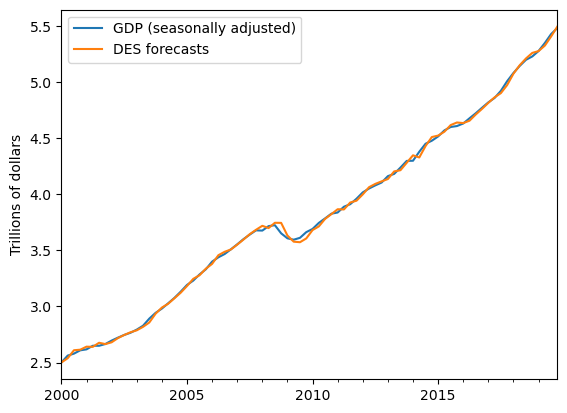

In [13]:
DES_results = ExponentialSmoothing(GDP,trend='additive',seasonal=None).fit()

GDP.plot(legend=True,label="GDP (seasonally adjusted)",ylabel="Trillions of dollars")
DES_results.fittedvalues.plot(legend=True,label="DES forecasts");
print(f"Sum of squared errors: {DES_results.sse : 6.5f}")

What about the parameter values? Now there is a new value 'smoothing_trend' that reflects the computer's optimally chosen value of $\beta$. As with any smoothing approach, things are working well when this settles down to a value that is far away from both zero and 1.

On the other hand, the value of $\alpha$ is still essentially 1. That may seem concerning based on what we saw earlier with SES, but the point of this new approach is that the model has more to learn about than just $\alpha$. As long as one of its parameters is not just zero or one, we can still feel like it is extracting meaningful information from the data. In this case, the trend is just so much stronger than the level as a feature of the data, that there is not much left for the model to learn about after settling on its choice of $\beta$.

In [14]:
DES_results.params

{'smoothing_level': np.float64(0.9999999850988388),
 'smoothing_trend': np.float64(0.4272004307584716),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(2.4629124928392985),
 'initial_trend': np.float64(0.03763170118308753),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Finally, we can again build out-of-sample forecasts beyond the end of the data.
The results are clearly more useful than our earlier forecasts based on SES. 
The key difference is that the forecasts now have a notion of which way the series is trending.

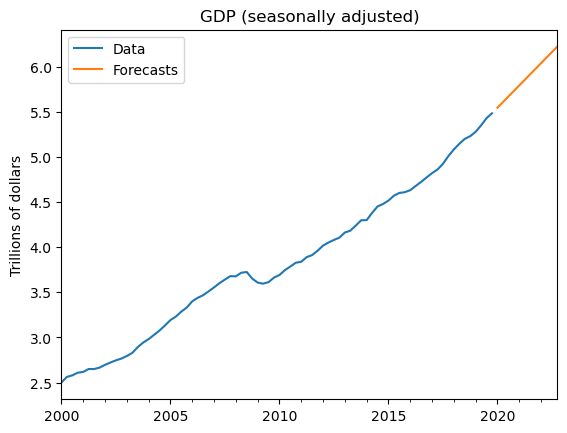

In [15]:
DES_forecasts_OOS = DES_results.forecast(12)

GDP.plot(legend=True,label="Data",
        title="GDP (seasonally adjusted)",
        ylabel="Trillions of dollars");
DES_forecasts_OOS.plot(legend=True,label="Forecasts");

The code below matches the results from statsmodels for all practical purposes. The small differences are because statsmodels uses a slightly different approach to initializing the filter and to optimizing the objective function (as also mentioned in the prior section).

In [16]:
# This function calculates DES forecasts, given choices of alpha and beta
def DES_manual(params):
    # Now params contains two values, alpha and beta
    alpha = params[0]
    beta = params[1]
    # Create an empty list of forecasts by copying the index of the raw data,
    # and adding one extra row for the last forecast
    forecasts = pd.Series(index=GDP.index.insert(len(GDP),GDP.index.max() + 1*GDP.index.freq),dtype='float64')
    # Initialize both the "level" and the "trend" forecast.
    # One common approach is to set the first "level" forecast equal to the first level of the data,
    # and the firest "trend" forecast equal to the difference of the first two observations.
    s = GDP.iloc[0]
    b = GDP.iloc[1] - GDP.iloc[0]
    # Any choice of s and b will rely on some of the early data, and in that sense, is slightly "cheating."
    # To be totally correct, we should exclude these first two observations from our SSE,
    # but this never makes a big enough difference to matter.
    forecasts.iloc[0] = s
    forecasts.iloc[1] = s+b
    # Now fill in the remaining forecasts following the double ES algorithm.
    for i in range(1,len(GDP)):
        s_old = s
        b_old = b
        s = alpha*GDP.iloc[i] + (1-alpha)*forecasts.iloc[i]
        b = beta*(s - s_old) + (1-beta)*b_old
        forecasts.iloc[i+1] = s+b
    return forecasts

# This function calculates the SSE of the DES procedure, given choices of alpha and beta.
# It uses the function defined just above.
def SSE_DES(params):
    forecasts = DES_manual(params)
    return ((GDP - forecasts)**2).sum()

# Finally, we ask an optimizer to minimize the SSE by searching over values of alpha and beta.
optimal_params = minimize(SSE_DES,[0.5,0.5],bounds=[[0,1],[0,1]]).x

# Print out the resulting values.
print(f"SSE: {SSE_DES(optimal_params) : 6.5f}")
print(f"Optimal alpha: {optimal_params[0] : 6.5f}")
print(f"Optimal beta: {optimal_params[1] : 6.5f}")

SSE:  0.04262
Optimal alpha:  1.00000
Optimal beta:  0.48254


Again, we can plot our forecasts calculated by hand against those from statsmodels to check that they are essentially the same.

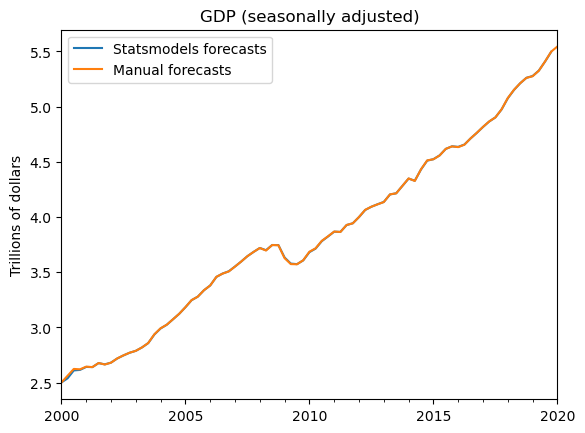

In [17]:
DES_results.fittedvalues.plot(legend=True,label="Statsmodels forecasts",
                              title="GDP (seasonally adjusted)",
                              ylabel="Trillions of dollars");
DES_manual(optimal_params).plot(legend=True,label="Manual forecasts");

## Triple exponential smoothing (Holt-Winters) with non-seasonally-adjusted GDP

Now let's look at the GDP data *without* seasonal adjustment. 

This data series is reported in *millions* of dollars. We convert it to trillions (divide by 1m) so it is comparable to the earlier series.

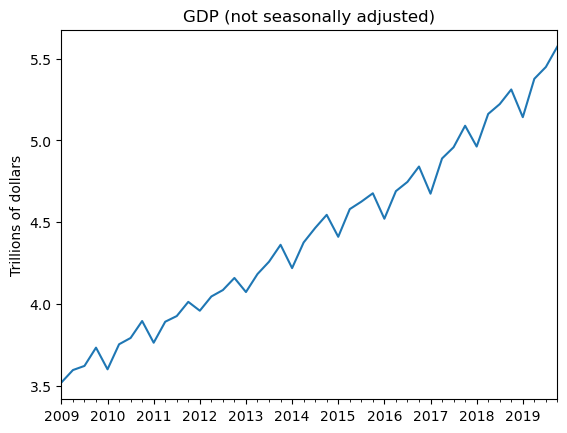

In [18]:
GDPNSA = fredapi.Fred().get_series('NA000334Q' , 
    observation_start = '2009-01-01', observation_end = '2019-12-31', 
    frequency='q', aggregation_method = 'eop').resample('QE').first()
GDPNSA = GDPNSA / 1e6
GDPNSA.plot(title="GDP (not seasonally adjusted)",
            ylabel="Trillions of dollars");

Let's see what happens if we try to apply double exponential smoothing to this series.
As we should expect, it fails to pick up on the seasonality of the series.
In some sense it is still right "on average", but, it is also always off by a large amount in any given quarter.

SSE:  0.28211
Smoothing parameter:  0.19763
Smoothing trend:  0.19763


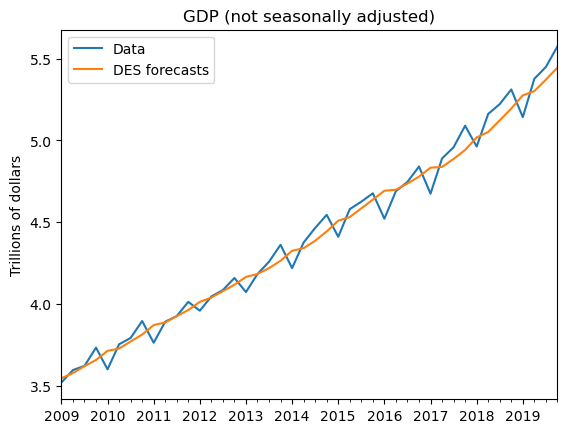

In [19]:
DES_results = ExponentialSmoothing(GDPNSA,trend='additive',seasonal=None).fit()
GDPNSA.plot(legend=True,label="Data",
            title="GDP (not seasonally adjusted)",
            ylabel="Trillions of dollars");
DES_results.fittedvalues.plot(legend=True,label="DES forecasts");

print(f"SSE: {DES_results.sse : 6.5f}")
print(f"Smoothing parameter: {DES_results.params['smoothing_level'] : 6.5f}")
print(f"Smoothing trend: {DES_results.params['smoothing_trend'] : 6.5f}")

Triple exponential smoothing quickly picks up on the seasonal patterns and gives us better quarterly forecasts. 
The SSE drops roughly in half.

We will not attempt to do this one by hand! But the math is described in the slides, and the basic idea is similar to the other approaches. It just adds a third, year-over-year component that the model also tries to learn about.

Like the trend, the seasonality pieces are thrown off by the initial COVID shock, but by 2023 they appear to be settling back down.

SSE:  0.03645
Smoothing level:  0.62767
Smoothing trend:  0.15878
Smoothing seasonal:  0.37233


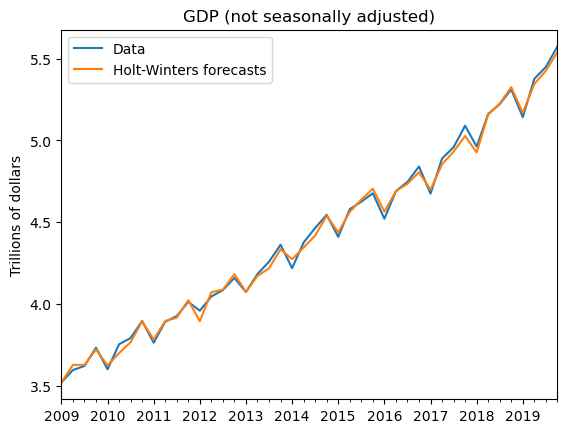

In [20]:
TES_results = ExponentialSmoothing(GDPNSA,trend='additive',seasonal='additive',seasonal_periods=4).fit()
GDPNSA.plot(legend=True,label="Data",
            title="GDP (not seasonally adjusted)",
            ylabel="Trillions of dollars");
TES_results.fittedvalues.plot(legend=True,label="Holt-Winters forecasts")

print(f"SSE: {TES_results.sse : 6.5f}")
print(f"Smoothing level: {TES_results.params['smoothing_level'] : 6.5f}")
print(f"Smoothing trend: {TES_results.params['smoothing_trend'] : 6.5f}")
print(f"Smoothing seasonal: {TES_results.params['smoothing_seasonal'] : 6.5f}")

The seasonal smoothing parameter comes out to zero, but that does *not* mean the model ignores seasonality. It means that the model does not *change* its initial guesses about the seasonal patterns, which were initialized to capture the seasonal patterns in the first two years or so. Seasonality is fairly stable in most series, so it's not too surprising that the model sees little reason to change its initial guess.

Finally, we can again build forecasts beyond the end of the data. Notice how they extrapolate both the trend and seasonality that the data exhibit towards the end of our window.

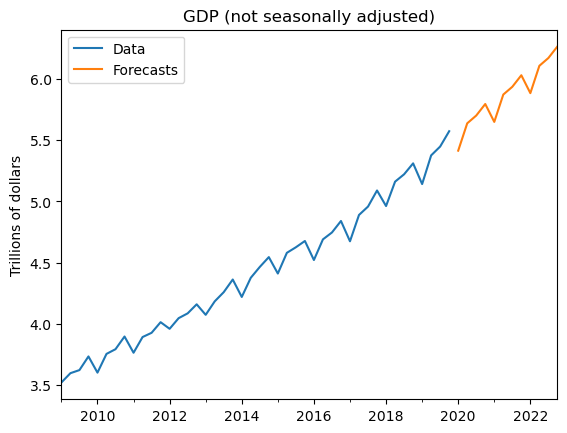

In [21]:
TES_forecasts_OOS = TES_results.forecast(12)
GDPNSA.plot(legend=True,label="Data",
           title="GDP (not seasonally adjusted)",
           ylabel="Trillions of dollars");
TES_forecasts_OOS.plot(legend=True,label="Forecasts");

The Holt-Winters approach is an extremely popular and powerful forecasting tool in practice! 

- It is often used in situations where you have an economic series to work with, need to quickly create forecasts, and don't have deep insights about the underlying economics of the series. 
- With many business and macreoeconomic data series, the most reliable features of the data are trend and seasonality, and any remaining part is much more difficult to model.
- Holt-Winters will quickly learn about trend and seasonality, and extrapolate them forward to a set of forecasts.
- In principle, you can then improve the forecasts by studying more carefully the residual part of the series, and trying to figure out a good way to model that. But this often turns out to be an extremely difficult exercise that requires lots of time and resources. When those time and resources are not available, Holt-Winters is a very good starting place that can give reasonable forecasts in a matter of seconds, and are actually quite difficult to beat.

# Stress-testing with Covid

Let's go back and repeat all the above analysis including the post-Covid period. We will see that the computer just gives up on learning about the level of the series and sets $\alpha$ to extreme values in all three approaches (sometimes close to zero, sometimes close to 1). This is especially clear in the plot of fitted values from the SES procedure. 

However, since Covid did not greatly disrupt the longer-term trend or seasonality in GDP, the models continue to perform well at extracting these features of the data. To be clear, both of them are thrown way off by the onset of that shock, and take a while to catch up, but by the end of 2024 they are back on track.

If you wanted to learn about the level aspect of the data more confidently, you could use only post-Covid data, or exclude the Covid period as an "outlier". However, on a deeper level the lesson of that experience was perhaps to not be too confident in our forecasts of short-run behavior in general.

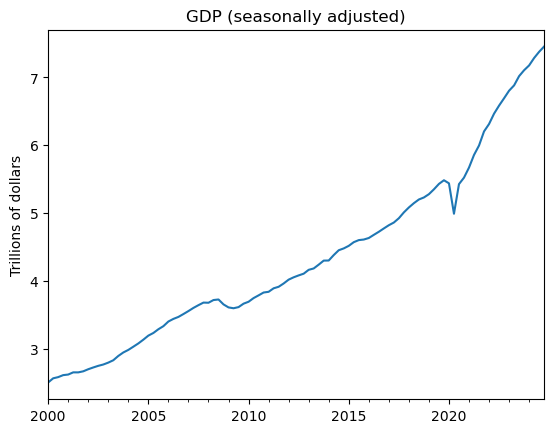

In [22]:
GDP = fredapi.Fred().get_series('GDP' , 
    observation_start = '2000-01-01', observation_end = '2024-12-31', 
    frequency='q', aggregation_method = 'eop').resample('QE').first()
GDP = GDP / 1000
GDP = GDP / 4
GDP.plot(title="GDP (seasonally adjusted)",ylabel="Trillions of dollars");

## SES for quarterly growth rate of seasonally-adjusted GDP, including post-Covid period

SSE:  204.92075
Smoothing level (alpha):  0.00000


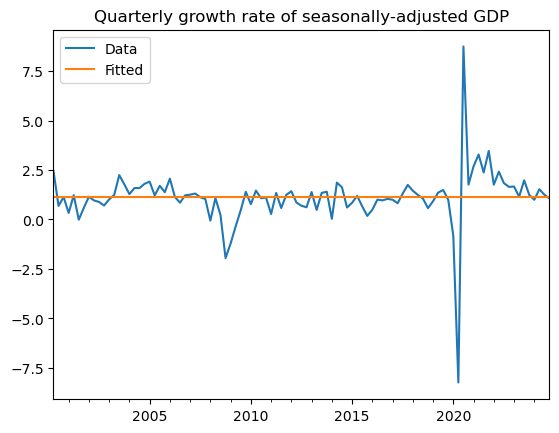

In [23]:
GDP_1q = 100*( GDP.diff() / GDP.shift() ).dropna()
SES_results = ExponentialSmoothing( GDP_1q, trend=None, seasonal=None ).fit()

GDP_1q.plot(title="Quarterly growth rate of seasonally-adjusted GDP",legend=True,label="Data");
SES_results.fittedvalues.plot(legend=True,label="Fitted");

print(f"SSE: {SES_results.sse : 6.5f}")
print(f"Smoothing level (alpha): {SES_results.params['smoothing_level'] : 6.5f}")

## Double exponential smoothing for level of seasonally-adjusted GDP, including post-Covid

SSE:  0.54520
Smoothing level (alpha):  0.88107
Smoothing trend:  0.09160


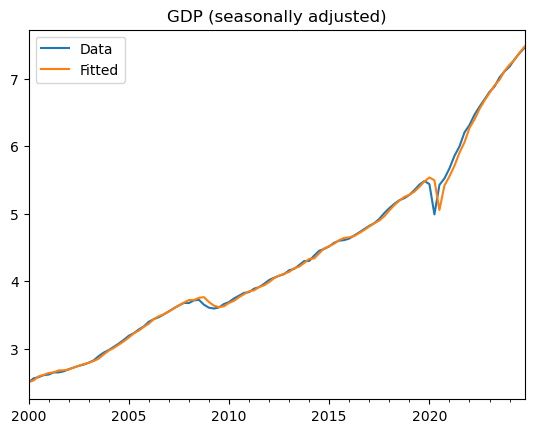

In [24]:
DES_results = ExponentialSmoothing(GDP,trend='additive',seasonal=None).fit()

GDP.plot(title="GDP (seasonally adjusted)",legend=True,label="Data");
DES_results.fittedvalues.plot(legend=True,label="Fitted");

print(f"SSE: {DES_results.sse : 6.5f}")
print(f"Smoothing level (alpha): {DES_results.params['smoothing_level'] : 6.5f}")
print(f"Smoothing trend: {DES_results.params['smoothing_trend'] : 6.5f}")

## Triple exponential smoothing for level of (not seasonally adjusted) GDP, including post-Covid

SSE:  0.51507
Smoothing level:  1.00000
Smoothing trend:  0.06528
Smoothing seasonal:  0.00000


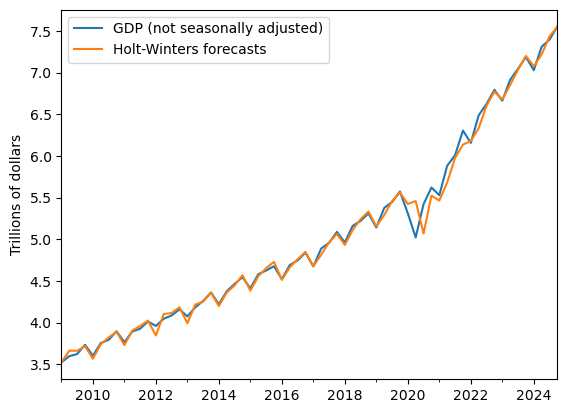

In [25]:
GDPNSA = fredapi.Fred().get_series('NA000334Q' , 
    observation_start = '2009-01-01', observation_end = '2024-12-31', 
    frequency='q', aggregation_method = 'eop').resample('QE').first()
GDPNSA = GDPNSA / 1e6

TES_results = ExponentialSmoothing(GDPNSA,trend='additive',seasonal='additive',seasonal_periods=4).fit()
GDPNSA.plot(legend=True,label="GDP (not seasonally adjusted)",ylabel="Trillions of dollars");
TES_results.fittedvalues.plot(legend=True,label="Holt-Winters forecasts")

print(f"SSE: {TES_results.sse : 6.5f}")
print(f"Smoothing level: {TES_results.params['smoothing_level'] : 6.5f}")
print(f"Smoothing trend: {TES_results.params['smoothing_trend'] : 6.5f}")
print(f"Smoothing seasonal: {TES_results.params['smoothing_seasonal'] : 6.5f}")